## Analysis notebook

In this notebook we will do the following:
1) Fit cross-validated Lasso, random forest, and XGBoost models
2) Identify the variables that are most and least important
3) Explore any multicollinearity and how the models handle it
4) Compare model AUC for the best performing model of each type (hold out data only)
5) Discuss throughout the notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.io import arff
import pprint

import os
import sys
from pathlib import Path

from sklearn.model_selection import train_test_split

project_root = Path().resolve().parents[0]
sys.path.append(str(project_root / "src"))

## load in a ton of code
from paths import CLEAN_DATA_DIR, MODELS_DIR, SEED
from utils import *
from models import *
from viz import *
from refit_performance import *

In [2]:
data = read_pickle(CLEAN_DATA_DIR, 'modeling_data.pkl')
ytrain = data['yTrain'] 
ytest = data['ytest'] 
Xtrain = data['Xtrain']
Xtest = data['Xtest']

Pickle file successfully loaded from: /Users/John/Documents/allProjects/feature-selection-analysis/data/clean/modeling_data.pkl


In [3]:
## fit the models
lasso_results = fit_lasso_cv(Xtrain, ytrain, seed=SEED)
best_rf = fit_rf_cv(Xtrain, ytrain, seed=SEED)
best_xgb = fit_xgb_cv(Xtrain, ytrain, seed=SEED)

Now let's write all of these to pickle files for safe keeping

In [4]:
write_pickle(MODELS_DIR, "lasso_results.pkl", lasso_results)
write_pickle(MODELS_DIR, "best_rf.pkl", lasso_results)
write_pickle(MODELS_DIR, "best_xgb.pkl", lasso_results)

Pickle file successfully written to: /Users/John/Documents/allProjects/feature-selection-analysis/data/models/lasso_results.pkl
Pickle file successfully written to: /Users/John/Documents/allProjects/feature-selection-analysis/data/models/best_rf.pkl
Pickle file successfully written to: /Users/John/Documents/allProjects/feature-selection-analysis/data/models/best_xgb.pkl


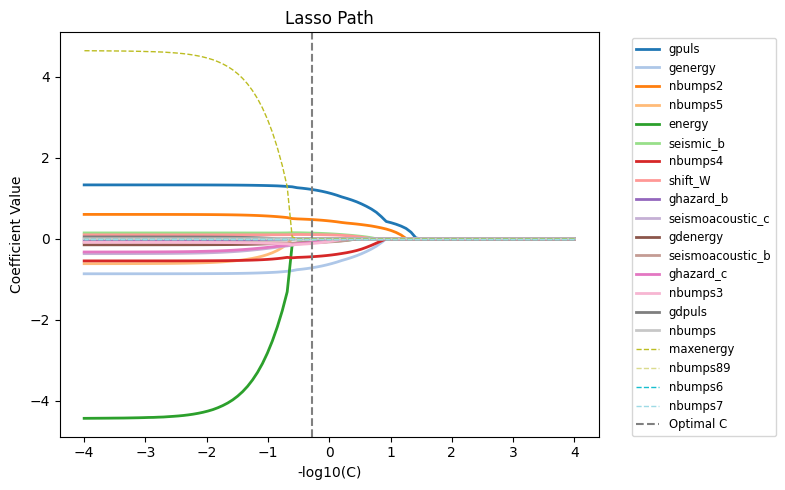

In [5]:
lasso_df = plot_lasso_paths(lasso_results)

The CV Lasso shows some intersting results. Most notably there are 4 variables shrunken to zero at the optimal penalty parameter. This means we will re-fit a logistic regression without these variables.

Additionally, the relationship between *energy* and *maxenergy* stands out. That is one of the clearest signs of of multicollinearity that I've ever seen. The coefficient's signs are nearly equal and opposite with one variable being shrunken all the way to zero while the other remains. We *could* remove this and re-fit; however that isn't necessary. This is one of the reasons I love Lasso regression - it is robust to multicollinearity. If we tried to do a stepwise regression we would need to exclude one of the two variables or risk the logistic regression failing to converge. Lasso regression selects the variables we want and does not require manually checking for multicollinearity. It may be helpful to do so in extremely high-dimensional spaces, but 20 predictors falls short of that threshold.

In [6]:
energy_corr = round(Xtrain['maxenergy'].corr(Xtrain['energy']),2)
print(f"Correlation between Energy and Max Energy: {energy_corr}")

Correlation between Energy and Max Energy: 0.99


Confirmed, that is extreme multicollinearity. 0.99 gives a VIF ~100, which is well beyond the typical tolerances of 5 or 10. Lasso excluded this for us, a pretty big win.

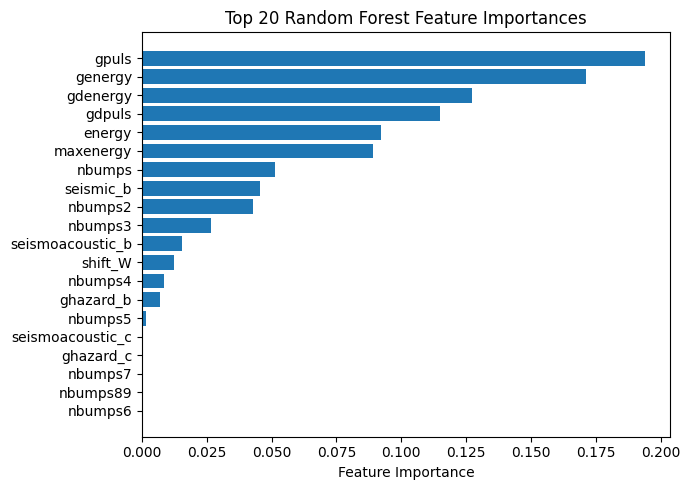

In [7]:
rf_df = plot_rf_feature_importance(best_rf, Xtrain.columns, top_n=20)

The random forest is interesting because it essentially eliminates 5 variables. The variables, *seismoacoustic_c, ghazard_c, nbumps7, nbumps89,* and *nbumps6* do not provide any value in separating cases and controls, therefore they have effectively 0 feature importance, but not exactly 0. There is still a small value in there, which will be evident in our final plots. 

It's interesting to see some overlap between the Lasso and Random Forest. The *nbumps6, nbumps7,* and *nbumps89* variables were shrunken to zero in the Lasso regression. We have consistency between a linear and non-linear model.

Notably, *energy* and *maxenergy* have nearly identical importances. Due to their redundant largely redundant information, these variables are contribution nearly the exact same value to the model. The model meets the required assumptions and fits because tree-based methods are robust to multicollinearity.

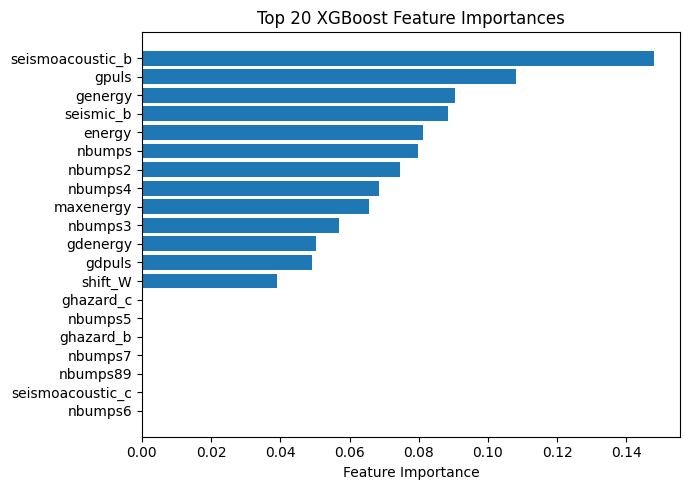

In [8]:
xgb_df = plot_xgb_feature_importance(best_xgb, Xtrain.columns, top_n=20)

The XGBoost varies quite a bit from our previous two methods because *seismoacoustic_b* is the most important feature, whereas it was not in the top 10 for Lasso or Random Forest. What do we do when models disagree significantly? Talk to experts. An expert may have knowledge explaining why these models disagree - without their feedback we cannot conclude if XGBoost is picking up on an important signal, or coincidental noise. Cross-functional teams combine data science and domain knowledge, allowing for expertise to guide model fitting and selection. This is an excellent example.

It's also worth noting that Random Forest, XGBoost, and Lasso agree that the *nbumps6, nbumps7, and nbumps89* features are not important. This confirms we could drop these and refit, however, they aren't going to impede performance for Random Forest or XGBoost. In the case of logistic regression, they need to be dropped. 

XGBoost and Random Forest agree that *seismoacoustic_c, ghazard_b* and *ghazard_c* are unimportant. These were not excluded from the Lasso regression.

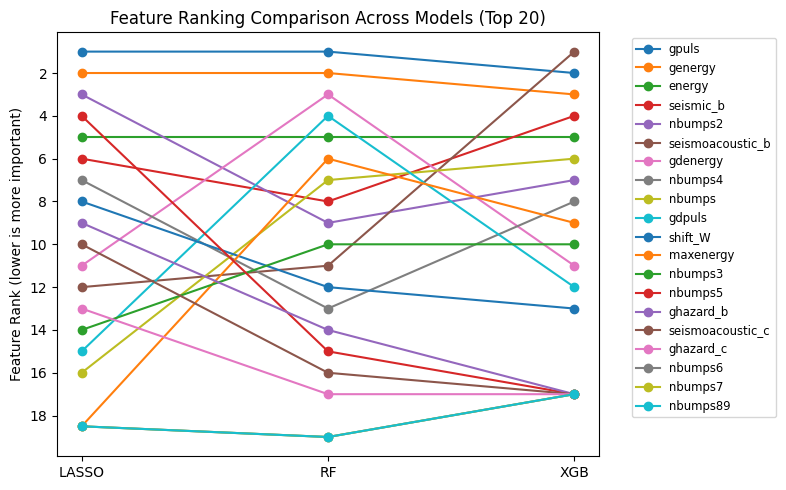

In [9]:
plot_feature_ranking_comparison(lasso_df, rf_df, xgb_df, top_n=20)

The bump plot is a bit chaotic. There is clearly some diagreement between the three methods, which is to be expected. The Random Forest and XGBoost seem more similar than either are to Lasso Regression. Still, this visual is a bit difficult to process without staring at it for quite some time.

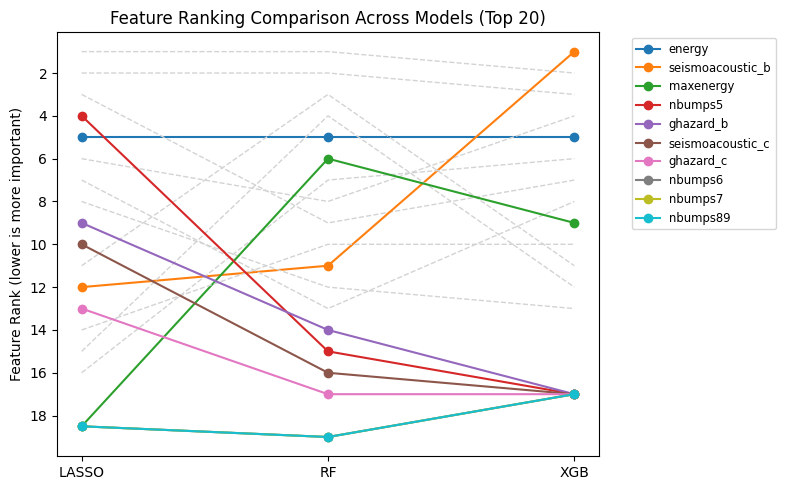

In [10]:
plot_feature_ranking_comparison(lasso_df, rf_df, xgb_df, top_n=20, selected_lines = True)

The truncated version above focuses on the variables with unique behaviors. The worst variables contribute no value in any of the methods, and we can see there are two variables that are consistent top performers across methods. 

*nbumps5* stands out because it is the 4th best variable in Lasso regression, outside the top 10 for Random Forest, and provides no value to XGBoost. I have seen this occur with other modeling approaches - my instinct is that *numbps5* shows some linear separability across classes, but this association is correlated with a combination of other features. This could explain why the non-linear methods believe it is unimportant. Its value is not unique, or overpowered by other predictors.

Finally, we see *maxenergy* is useful for Random Forest and XGBoost despite the near perfect correlation with *energy.* If our goal were to re-fit and maximize performance, then we could exclude *maxenergy* from future models because it provides redundant information. It is worth noting that without Lasso or calculating the VIF we would not identify the multicollinearity. 

### Model Performance

We need to refit a logistic regression with only the non-zero coefficients from the Lasso, and then predict probabilities, plot ROC curves, and compare AUC values.

In [12]:
logit_model = refit_logistic_from_lasso(lasso_results, Xtrain, ytrain)

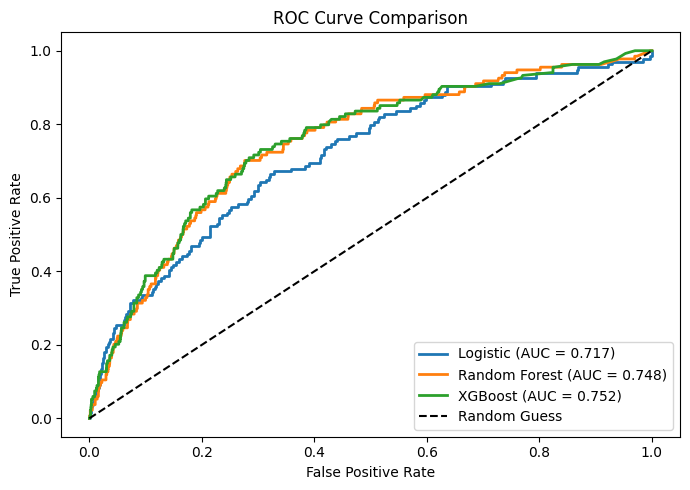

In [13]:
plot_model_roc_auc_comparison(logit_model, best_rf, best_xgb, Xtest, ytest)

The XGBoost picked up on a unique signal from *seismoacoustic_b* and performed the best. It's AUC is comparable to Random Forest, but far superior to Logistic Regression. This confirms that the non-linear methods are the better at predicting with this dataset; however, all three methods are better than guessing at random.

#### What does this mean for feature selection?

This does not mean one approach is always right or wrong, yet in this case the models with no explicit feature selection outperformed the explicit feature selection for the Logistic regression. *What should you say the next time someone asks about feature selection?* If you used Random Forest or XGBoost then you performed feature selection while fitting the model. For Logistic regression, you *always* need to perform explicit feature selection. This is an excellent example of why all Data Scientists need to know the fundamentals of the algorithms they're fitting. Simply calling model.fit() may lead to fundamental flaws in the modeling process.